In [1]:
import sys
print(sys.version)
print(sys.path)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
['/Users/tokudo/Develop/grips/unicorn/notebooks', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python36.zip', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/lib-dynload', '', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/aeosa', '/Users/tokudo/Develop/grips/grina', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/locket-0.2.1-py3.6.egg', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/IPython/extensions', '/Users/tokudo/.ipython', '/Users/tokudo/.local/lib/python3.6/site-packages']


In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
out_dir = os.path.join("..", "out", "202202")
out_dir_names = ["edgelist", "features", "adjacency"]
for out_dir_name in out_dir_names:
    out_path = os.path.join(out_dir, out_dir_name)
    if not os.path.exists(out_path):
        os.makedirs(out_path)

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

In [5]:
fpath = os.path.join("..", "data", "cb-insights_global-unicorn-club_2022.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})
df["Valuation($B) flaot"] = df['Valuation ($B) '].apply(trans2float)
df["DateTime Joined"] = df["Date Added"].apply(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"))
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26


In [6]:
df["Valuation($B) flaot"].describe()

count    1000.000000
mean        3.307270
std         7.405112
min         1.000000
25%         1.070000
50%         1.600000
75%         3.100000
max       140.000000
Name: Valuation($B) flaot, dtype: float64

In [7]:
# Unicornに重複がある場合に、suffixとして"_"を付与。
duplicated_company_idx = (df["Company"].duplicated(), "Company")
df.loc[duplicated_company_idx] = df.loc[duplicated_company_idx].apply(func=lambda x: str(x) + "+")
df[df["Company"].duplicated()]

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined


In [8]:
def clean(element):
    return element.strip()

In [9]:
# UnicornとInvestorのエッジリストの作成
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Stripe
Digital Currency Group
Stripe
Digital Currency Group
Movile
Bitmain Technologies


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,Bytedance,Sequoia Capital China
1,Bytedance,SIG Asia Investments
2,Bytedance,Sina Weibo
3,Bytedance,Softbank Group
4,SpaceX,Founders Fund
...,...,...
2825,Betterfly,DST Global
2826,Betterfly,Endeavor
2827,Dune Analytics,Multicoin Capital
2828,Dune Analytics,Coatue Management


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join(out_dir, "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join(out_dir, "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join(out_dir, "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]
Done!!


# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation ($B),Date Added,Country,Category,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
1,SIG Asia Investments,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
2,Sina Weibo,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
3,Softbank Group,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
4,Founders Fund,SpaceX,$100.30,2012/12/1,United States,Other,100.3,2012-12-01


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Category": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                     Country  \
                                       sum count       mean <lambda_0>   
0        .406 Ventures                1.70     1   1.700000          1   
1          01 Advisors                9.35     2   4.675000          1   
2             10T Fund                7.10     1   7.100000          1   
3                  14W                2.50     2   1.250000          1   
4      14W. ForgeLight                1.10     1   1.100000          1   
...                ...                 ...   ...        ...        ...   
1192     iTech Capital                1.00     1   1.000000          1   
1193  iVision Ventures                1.00     1   1.000000          1   
1194    index Ventures               33.00     1  33.000000          1   
1195            next47                4.60     3   1.533333          2   
1196       s28 Capital                1.40     1   1.400000          1   

                                Category  \
                          set <lambda_0>   
0             {United States}          1   
1             {United States}          2   
2             {United States}          1   
3             {United States}          2   
4            {United Kingdom}          1   
...                       ...        ...   
1192            {Netherlands}          1   
1193                  {China}          1   
1194         {United Kingdom}          1   
1195  {Israel, United States}          3   
1196          {United States}          1   

                                                           Company  \
                                                    set <lambda_0>   
0                         {Data management & analytics}          1   
1                                   {Fintech, Hardware}          2   
2                                             {Fintech}          1   
3                {Internet software & services, Health}          2   
4                                             {Fintech}          1   
...                                                 ...        ...   
1192                                         {Hardware}          1   
1193              {Supply chain, logistics, & delivery}          1   
1194                                          {Fintech}          1   
1195  {Fintech, Cybersecurity, Supply chain, logisti...          3   
1196                                    {Cybersecurity}          1   

                              DateTime Joined  
                          set             min  
0                    {Reltio}      2021-11-04  
1          {Tipalti, Density}      2020-10-06  
2                    {Gemini}      2021-11-19  
3      {K Health, Fever Labs}      2021-01-19  
4        {The Bank of London}      2021-11-30  
...                       ...             ...  
1192                {BitFury}      2018-11-06  
1193        {Keenon Robotics}      2021-09-15  
1194                {Revolut}      2018-04-26  
1195  {Bringg, Verkada, Pipe}      2020-01-29  
1196           {Panther Labs}      2021-12-02  

[1197 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,.406 Ventures,1.70,1,1.700,1,{United States},1,{Data management & analytics},1,{Reltio},2021-11-04
1,01 Advisors,9.35,2,4.675,1,{United States},2,"{Fintech, Hardware}",2,"{Tipalti, Density}",2020-10-06
2,10T Fund,7.10,1,7.100,1,{United States},1,{Fintech},1,{Gemini},2021-11-19
3,14W,2.50,2,1.250,1,{United States},2,"{Internet software & services, Health}",2,"{K Health, Fever Labs}",2021-01-19
4,14W. ForgeLight,1.10,1,1.100,1,{United Kingdom},1,{Fintech},1,{The Bank of London},2021-11-30


In [23]:
analysis_invest_df.to_csv(os.path.join(out_dir, "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,EXOR Seeds,0.001672,0.000000,8.839607e-15,0.001672,0.000850,1.00,1,1.00,1,{United Arab Emirates},1,{Other},1,{Emerging Markets Property Group},2020-04-28
1,Kae Capital,0.001672,0.000000,2.010840e-02,0.236505,0.000381,2.50,1,2.50,1,{India},1,{Internet software & services},1,{Zetwerk},2021-08-20
2,3i Group,0.001672,0.000000,7.220548e-03,0.212713,0.000435,5.00,1,5.00,1,{United Kingdom},1,{Other},1,{Howden Group Holdings},2020-09-29
3,Mundi Ventures,0.001672,0.000000,5.788680e-04,0.173077,0.000484,1.00,1,1.00,1,{Singapore},1,{Fintech},1,{bolttech},2021-07-01
4,Multicoin Capital,0.001672,0.000000,9.920689e-03,0.221972,0.000432,1.00,1,1.00,1,{Norway},1,{Data management & analytics},1,{Dune Analytics},2022-02-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,CyberStarts,0.001672,0.000000,2.057145e-02,0.237658,0.000365,1.00,1,1.00,1,{United States},1,{Cybersecurity},1,{Noname Security},2021-12-15
1193,Chicago Ventures,0.003344,0.000147,4.221048e-03,0.201975,0.000704,3.72,2,1.86,1,{United States},2,"{Fintech, Supply chain, logistics, & delivery}",2,"{Sunbit, Project44}",2021-05-20
1194,Cool Japan Fund,0.001672,0.000000,3.826238e-05,0.144487,0.000631,1.22,1,1.22,1,{Japan},1,{Other},1,{Spiber},2021-09-08
1195,Max Ventures,0.003344,0.002698,9.553593e-04,0.179363,0.001093,3.00,2,1.50,1,{United States},2,"{Other, Health}",2,"{K Health, Uplight}",2021-01-19


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,VAST Data,0.031031,0.003055,0.009506,0.347311,0.001194,$3.70,2020/4/16,United States,Data management & analytics,"[Norwest Venture Partners, Goldman Sachs, De...",3.7,2020-04-16
1,J&T Express,0.053053,0.005252,0.008817,0.331583,0.001784,$20.00,2021/4/7,Indonesia,"Supply chain, logistics, & delivery","[Hillhouse Capital Management, Boyu Capital, ...",20.0,2021-04-07
2,Deezer,0.002002,0.000208,0.000093,0.234200,0.000382,$1.40,2018/8/2,France,Internet software & services,"[Orange Digital Ventures, Access Industries]",1.4,2018-08-02
3,Miro,0.064064,0.001789,0.098816,0.361497,0.001717,$17.50,2022/1/5,United States,Internet software & services,"[Accel, AltaIR Capital, Technology Crossover...",17.5,2022-01-05
4,Swiggy,0.012012,0.000000,0.006660,0.310731,0.000521,$10.70,2018/6/21,India,"Supply chain, logistics, & delivery","[Accel India, SAIF Partners, Norwest Venture...",10.7,2018-06-21


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 97
ノード数に対するコンポーネント数の割合: 8.10%
投資家コンポーネント上位10件のサイズ
[967   5   5   5   4   4   3   3   3   3]
ネットワーク密度: 100.00%


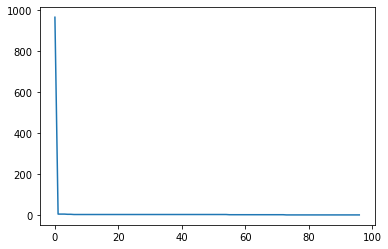

In [28]:
describe_components(investor_graph)

コンポーネント数: 97
ノード数に対するコンポーネント数の割合: 9.70%
投資家コンポーネント上位10件のサイズ
[898   2   2   2   2   2   2   1   1   1]
ネットワーク密度: 3.44%


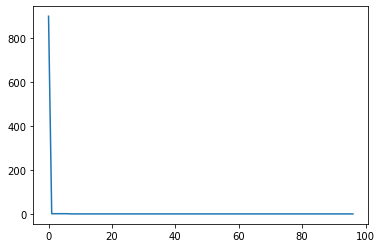

In [29]:
describe_components(company_graph)

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [30]:
df.sort_values(by=["Date Added"])

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
603,Veepee,$1.38,2007/7/20,France,E-commerce & direct-to-consumer,"[Summit Partners, Qatar Holding]",1.38,2007-07-20
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.60,2011-12-12
105,Vice Media,$5.70,2011/4/2,United States,Internet software & services,"[Technology Crossover Ventures, A&E Televisio...",5.70,2011-04-02
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.30,2012-12-01
380,Avant,$2.00,2012/12/17,United States,Artificial intelligence,"[RRE Ventures, Tiger Global, August Capital]",2.00,2012-12-17
...,...,...,...,...,...,...,...,...
635,Loadsmart,$1.30,2022/2/1,United States,"Supply chain, logistics, & delivery","[Chromo Invest, Maersk Growth, BlackRock]",1.30,2022-02-01
507,Wayflyer,$1.60,2022/2/1,Ireland,Fintech,"[QED Investors, DST Global, Left Lane Capital]",1.60,2022-02-01
998,Betterfly,$1.00,2022/2/1,Chile,Artificial intelligence,"[QED Investors, DST Global, Endeavor]",1.00,2022-02-01
482,Productboard,$1.70,2022/2/2,United States,Internet software & services,"[Index Ventures, Kleiner Perkins Caufield & B...",1.70,2022-02-02


In [31]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [32]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,3.409294,1738.74,1.0,100.3,510.0
China,3.410359,569.53,1.0,140.0,167.0
United Kingdom,4.622564,180.28,1.0,40.0,39.0
India,3.035085,179.07,1.0,21.0,59.0
Germany,2.888000,72.20,1.0,11.0,25.0


In [33]:
industry_group = df.groupby("Category").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Category,,,,,
Fintech,3.921311,807.79,1.0,95.0,206.0
Internet software & services,2.952228,543.21,1.0,40.0,184.0
E-commerce & direct-to-consumer,2.955185,319.16,1.0,20.0,108.0
Artificial intelligence,4.077143,313.94,1.0,140.0,77.0
Other,4.795455,263.75,1.0,100.3,55.0


In [34]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

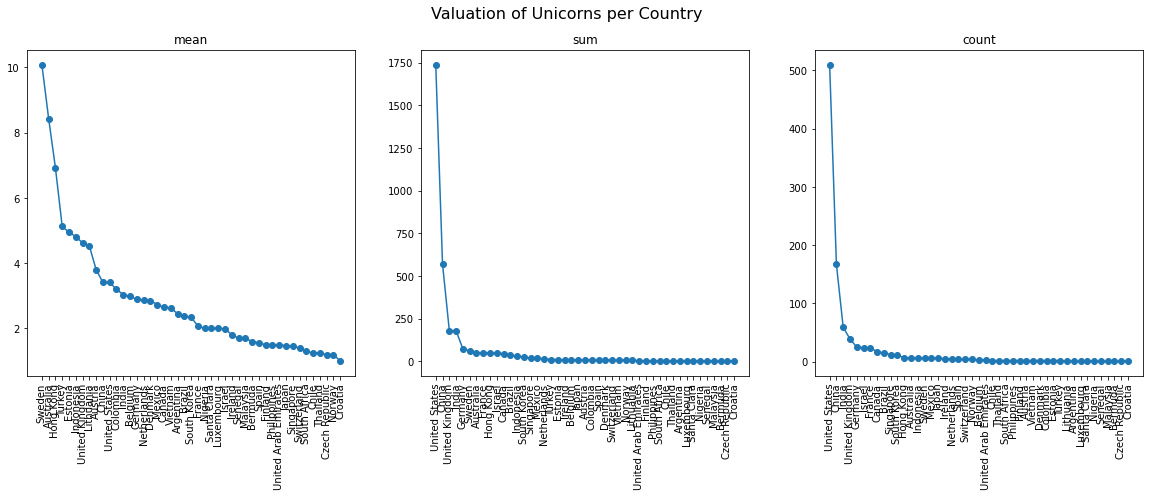

Complete output to ../out/2022/features/value_per_country.png


In [35]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join(out_dir, "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

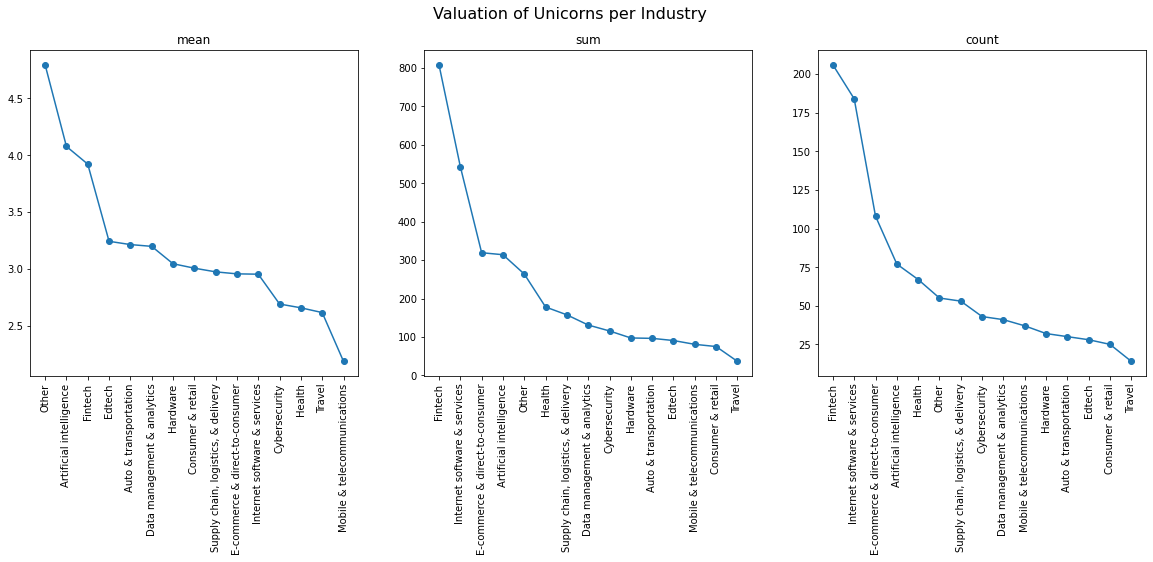

Complete output to ../out/2022/features/value_per_industry.png


In [36]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join(out_dir, "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [37]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

1000


,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2017-04-07,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0
2012-12-01,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3
2014-01-23,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0
2011-12-12,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6
2018-10-26,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0
...,...,...,...,...,...,...,...
2022-01-26,Fever Labs,$1.00,2022/1/26,United States,Internet software & services,"[Accel, 14W, GS Growth]",1.0
2022-01-26,Minio,$1.00,2022/1/26,United States,Data management & analytics,"[General Catalyst, Nexus Venture Partners, D...",1.0
2022-01-27,Esusu,$1.00,2022/1/27,United States,Fintech,"[Next Play Ventures, Zeal Capital Partners, ...",1.0


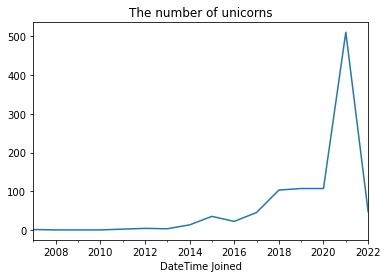

In [38]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join(out_dir, "features", "n_unicorns_time_change.png"))

# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [39]:
company_graph_pd

,source,target
0,VAST Data,Rubicon Global
1,VAST Data,Swiggy
2,VAST Data,Klook
3,VAST Data,Graphcore
4,VAST Data,SMS Assist
...,...,...
13841,Veriff,Fever Labs
13842,ActiveCampaign,Intercom
13843,PayFit,Fever Labs
13844,InMobi,Interos


In [40]:
uc_date_columns = ["Company", "Date Added", "Country", "Category", "Valuation($B) flaot"]
uc_date = df.loc[:, uc_date_columns]
uc_date.loc[:, "DateTime Joined"] = uc_date["Date Added"].apply(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"))
uc_date.set_index("Company", inplace=True)
elem_dict = uc_date.to_dict("index")

In [41]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Rubicon Global,VAST Data
1,Swiggy,VAST Data
2,Klook,VAST Data
3,Graphcore,VAST Data
4,SMS Assist,VAST Data
...,...,...
13841,Veriff,Fever Labs
13842,Intercom,ActiveCampaign
13843,PayFit,Fever Labs
13844,InMobi,Interos


In [42]:
# チェック用
print(elem_dict["Flexport"]["Date Added"])
# print(elem_dict["Knotel"]["Date Added"])
print(elem_dict["Gong"]["Date Added"])
print(elem_dict["VAST Data"]["Date Added"])
# print(elem_dict["Dave"]["Date Added"])
# print(elem_dict["Udemy"]["Date Added"])

2018/4/30
2020/8/12
2020/4/16


In [43]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [44]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Category"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Category"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [45]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [46]:
val_size[:10]

[100.45323741007195,
 117.4820143884892,
 162.80575539568343,
 102.26618705035972,
 111.46043165467626,
 100.0,
 106.4748201438849,
 105.17985611510791,
 106.4748201438849,
 102.07194244604317]

In [47]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join(out_dir, "sen2jun_dgraph"))

In [48]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [49]:
comp_dgraph_centrality_df.to_csv(os.path.join(out_dir, "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [50]:
investor_graph_pd

,source,target
0,EXOR Seeds,OLX Group
1,EXOR Seeds,KCK Group
2,Kae Capital,Sequoia Capital India
3,Kae Capital,Accel
4,3i Group,Huagai Capital
...,...,...
2500,Revolution Growth,SWaN & Legend Ventures
2501,Shenzhen Qianhe Capital Management Co.,Oceanwide Holdings
2502,Sands Capital,International Finance Corporation
2503,Sands Capital,Summit Partners


In [51]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [52]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,EXOR Seeds,OLX Group
1,EXOR Seeds,KCK Group
2,Sequoia Capital India,Kae Capital
3,Accel,Kae Capital
4,3i Group,Huagai Capital
...,...,...
2500,Revolution Growth,SWaN & Legend Ventures
2501,Shenzhen Qianhe Capital Management Co.,Oceanwide Holdings
2502,Sands Capital,International Finance Corporation
2503,Summit Partners,Sands Capital


In [53]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [54]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join(out_dir, "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,EXOR Seeds,0.001706,0.000000,7.126810e-50,0.000000,0.000499,0.000000,0.001706,1,2,...,1.00,1,1.000000,1,{United Arab Emirates},1,{Other},1,{Emerging Markets Property Group},2020-04-28
1,OLX Group,0.001706,0.000000,6.211229e-45,0.001706,0.001316,0.001706,0.000000,0,0,...,1.00,1,1.000000,1,{United Arab Emirates},1,{Other},1,{Emerging Markets Property Group},2020-04-28
2,KCK Group,0.001706,0.000000,2.971880e-47,0.000853,0.000711,0.000853,0.000853,1,1,...,1.00,1,1.000000,1,{United Arab Emirates},1,{Other},1,{Emerging Markets Property Group},2020-04-28
3,Sequoia Capital India,0.034983,0.001702,4.988946e-20,0.018606,0.000631,0.004266,0.030717,6,445,...,88.33,26,3.397308,3,"{India, Indonesia, United States}",10,"{Supply chain, logistics, & delivery, E-commer...",26,"{Razorpay, apna, Pristyn Care, Groww, CarDekho...",2017-07-25
4,Kae Capital,0.001706,0.000000,4.821948e-13,0.023773,0.000539,0.001706,0.000000,0,0,...,2.50,1,2.500000,1,{India},1,{Internet software & services},1,{Zetwerk},2021-08-20


In [55]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [56]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.863698,-0.022132,0.181195,0.081509,0.684597,0.970417,0.523255,0.584652,NaN,NaN,1.000000,NaN,0.825851,0.991628,0.043929,0.833960,0.906102,0.991628
Betweenness Centrality,0.863698,1.000000,-0.011850,0.178360,0.110470,0.700710,0.801902,0.419832,0.428562,NaN,NaN,0.863698,NaN,0.693736,0.863295,0.029381,0.731521,0.728153,0.863295
Eigen Centrality,-0.022132,-0.011850,1.000000,0.040584,0.088683,-0.020121,-0.019831,-0.036774,-0.016675,NaN,NaN,-0.022132,NaN,-0.013027,-0.016276,-0.001834,-0.017242,-0.022906,-0.016276
Closeness Centrality,0.181195,0.178360,0.040584,1.000000,0.324496,0.552324,0.033979,-0.030385,-0.144109,NaN,NaN,0.181195,NaN,0.068774,0.151124,-0.024638,0.173929,0.185346,0.151124
Page Rank,0.081509,0.110470,0.088683,0.324496,1.000000,0.404529,-0.036409,-0.210059,-0.118339,NaN,NaN,0.081509,NaN,0.018328,0.070589,-0.057668,0.071053,0.057336,0.070589
In-degree Centrality,0.684597,0.700710,-0.020121,0.552324,0.404529,1.000000,0.488356,0.267412,0.183613,NaN,NaN,0.684597,NaN,0.485745,0.650784,0.036040,0.600607,0.634792,0.650784
Out-degree Centrality,0.970417,0.801902,-0.019831,0.033979,-0.036409,0.488356,1.000000,0.537853,0.639111,NaN,NaN,0.970417,NaN,0.827795,0.971594,0.040653,0.799458,0.874501,0.971594
Elongation,0.523255,0.419832,-0.036774,-0.030385,-0.210059,0.267412,0.537853,1.000000,0.712220,NaN,NaN,0.523255,NaN,0.445106,0.494305,0.091783,0.460661,0.602882,0.494305
Expansion,0.584652,0.428562,-0.016675,-0.144109,-0.118339,0.183613,0.639111,0.712220,1.000000,NaN,NaN,0.584652,NaN,0.559948,0.577510,0.083217,0.462323,0.635950,0.577510
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


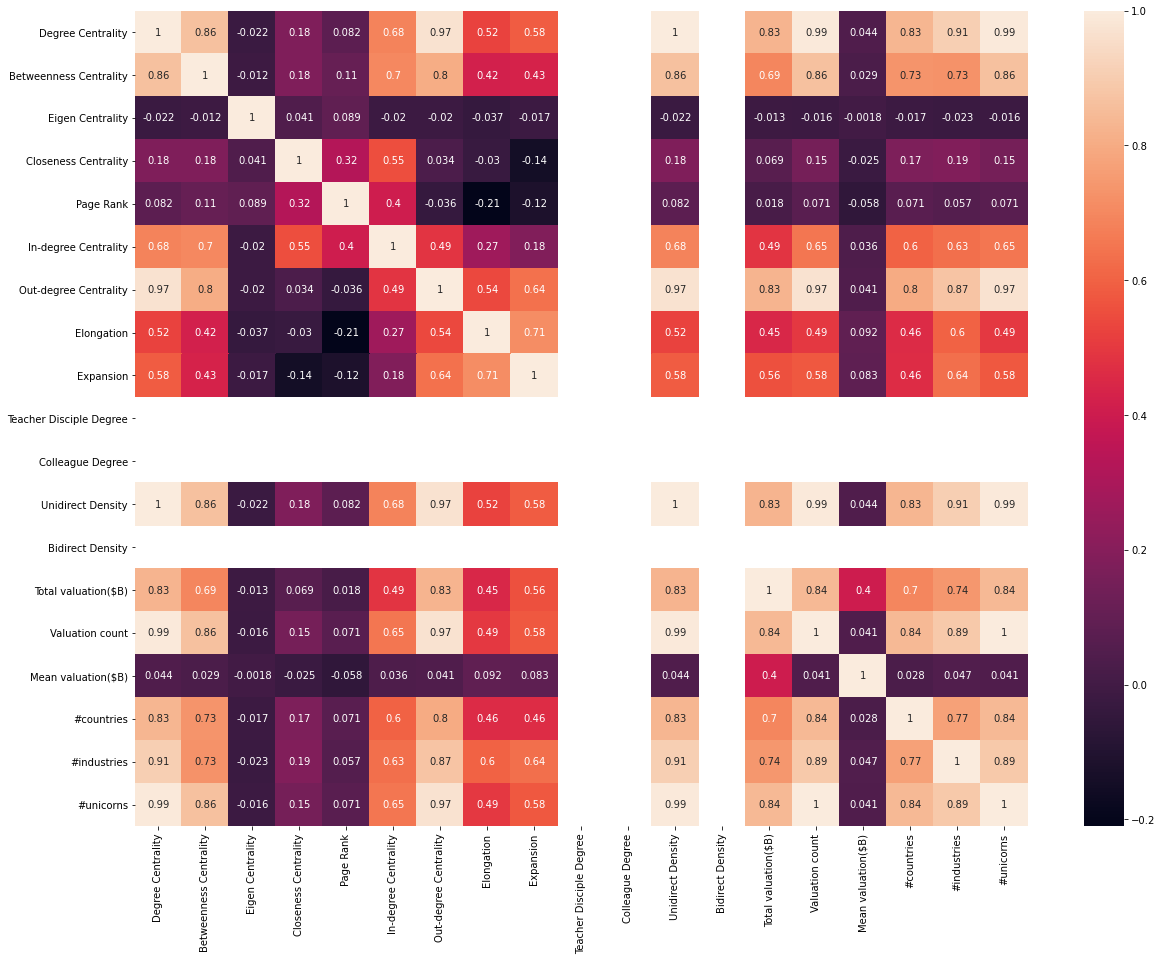

In [57]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join(out_dir, "features", "investor_correlation.png"))

In [58]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,Bytedance,140.0
1,SpaceX,100.3
2,Stripe,95.0
3,Klarna,45.6
4,Epic Games,42.0


In [59]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [60]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Rubicon Global,0.016502,0.000000,1.104478e-93,0.009935,0.000443,0.005501,0.011001,7,640,1.0,...,0.008242,0.0,$1.07,2017/8/25,United States,Other,"[Goldman Sachs, Leonardo DiCaprio, Promecap]",1.07,2017-08-25,1.07
VAST Data,0.034103,0.001937,1.670623e-57,0.056733,0.000890,0.018702,0.015402,6,401,1.0,...,0.017033,0.0,$3.70,2020/4/16,United States,Data management & analytics,"[Norwest Venture Partners, Goldman Sachs, De...",3.70,2020-04-16,3.70
Swiggy,0.013201,0.000000,5.335019e-108,0.001100,0.000368,0.001100,0.012101,6,402,1.0,...,0.006593,0.0,$10.70,2018/6/21,India,"Supply chain, logistics, & delivery","[Accel India, SAIF Partners, Norwest Venture...",10.70,2018-06-21,10.70
Klook,0.073707,0.003228,6.599511e-71,0.056873,0.000754,0.035204,0.038504,9,527,1.0,...,0.036813,0.0,$1.35,2018/8/7,Hong Kong,Travel,"[Sequoia Capital China, Goldman Sachs, Matri...",1.35,2018-08-07,1.35
Graphcore,0.009901,0.000392,1.213729e-105,0.001467,0.000397,0.001100,0.008801,7,421,1.0,...,0.004945,0.0,$2.77,2018/12/18,United Kingdom,Artificial intelligence,"[Dell Technologies Capital, Pitango Venture C...",2.77,2018-12-18,2.77


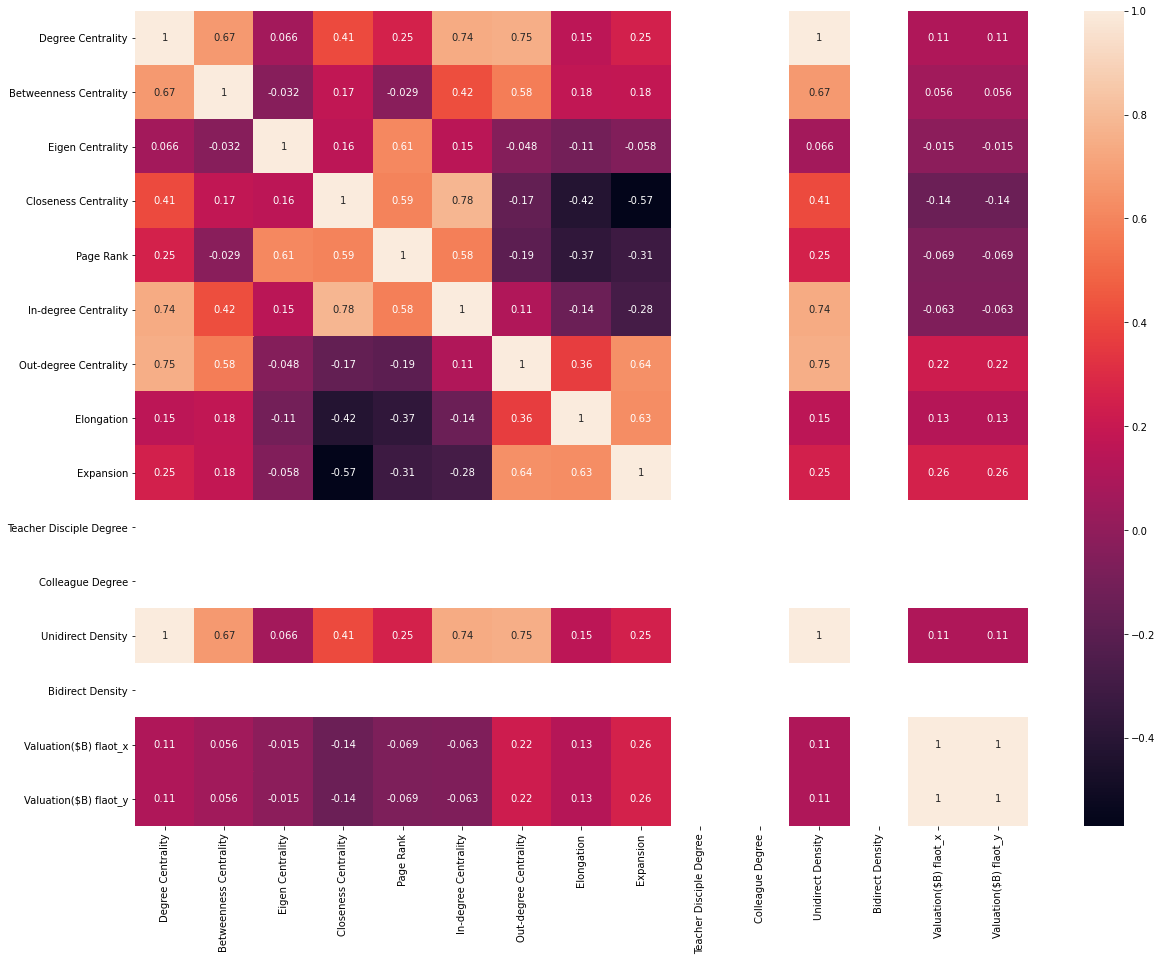

In [61]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join(out_dir, "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

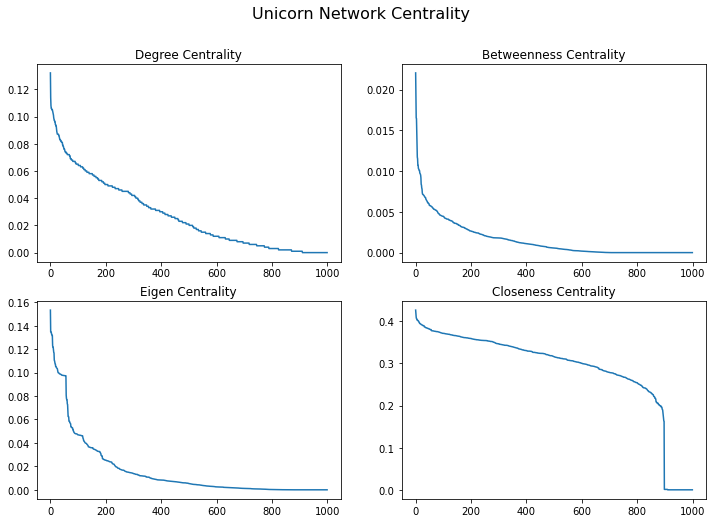

In [62]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "unicorn_network_centrality.png"))

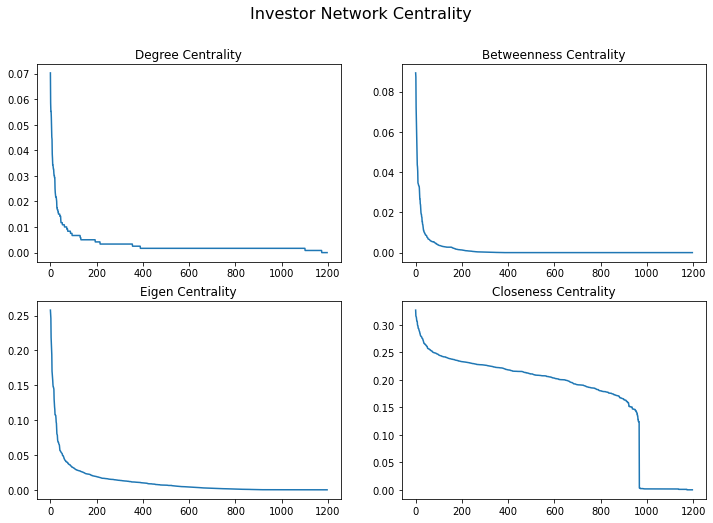

In [63]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "investor_network_centrality.png"))

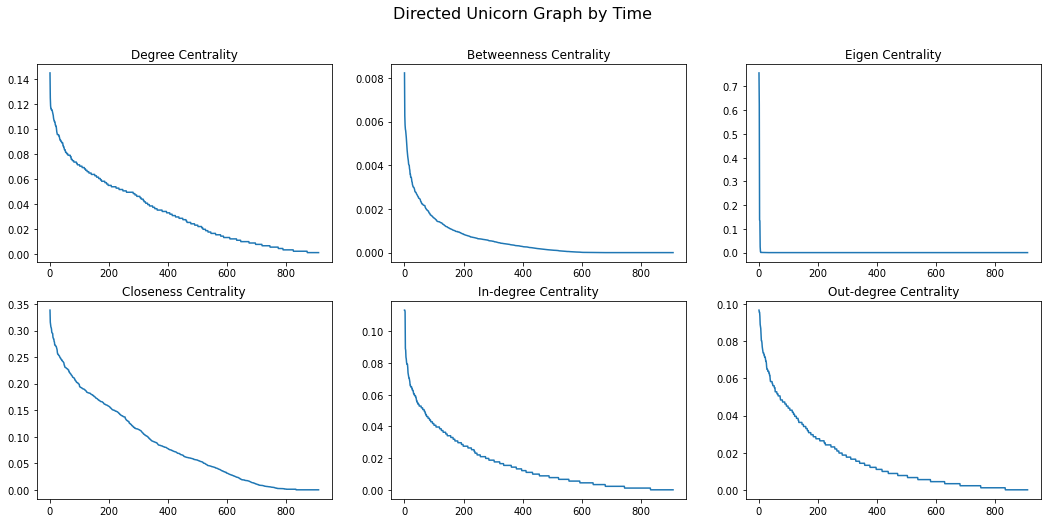

In [64]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "directed_unicorn_centrality.png"))

# データの出力

In [65]:
investor_centrality_df.to_csv(os.path.join(out_dir, "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join(out_dir, "features", "unicorn_centrality.csv"))

In [66]:
unicorn_data_df.corr().to_csv(os.path.join(out_dir, "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join(out_dir, "features", "investor_correlation.csv"))

## 企業 - 国・産業ネットワーク

In [67]:
df

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26
...,...,...,...,...,...,...,...,...
995,Fever Labs,$1.00,2022/1/26,United States,Internet software & services,"[Accel, 14W, GS Growth]",1.0,2022-01-26
996,Minio,$1.00,2022/1/26,United States,Data management & analytics,"[General Catalyst, Nexus Venture Partners, D...",1.0,2022-01-26
997,Esusu,$1.00,2022/1/27,United States,Fintech,"[Next Play Ventures, Zeal Capital Partners, ...",1.0,2022-01-27
998,Betterfly,$1.00,2022/2/1,Chile,Artificial intelligence,"[QED Investors, DST Global, Endeavor]",1.0,2022-02-01


In [68]:
country_industry_df = pd.merge(comp_dgraph_df, df[["Company", "Country", "Category", "DateTime Joined"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Category", "DateTime Joined"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()
country_industry_df.to_csv(os.path.join(out_dir, "edgelist", "country_industry_dgraph.csv"))

In [69]:
country_dgraph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_dgraph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join(out_dir, "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join(out_dir, "adjacency", "country_graph.csv"))

In [70]:
country_graph_matrix.max().max()

5390.0

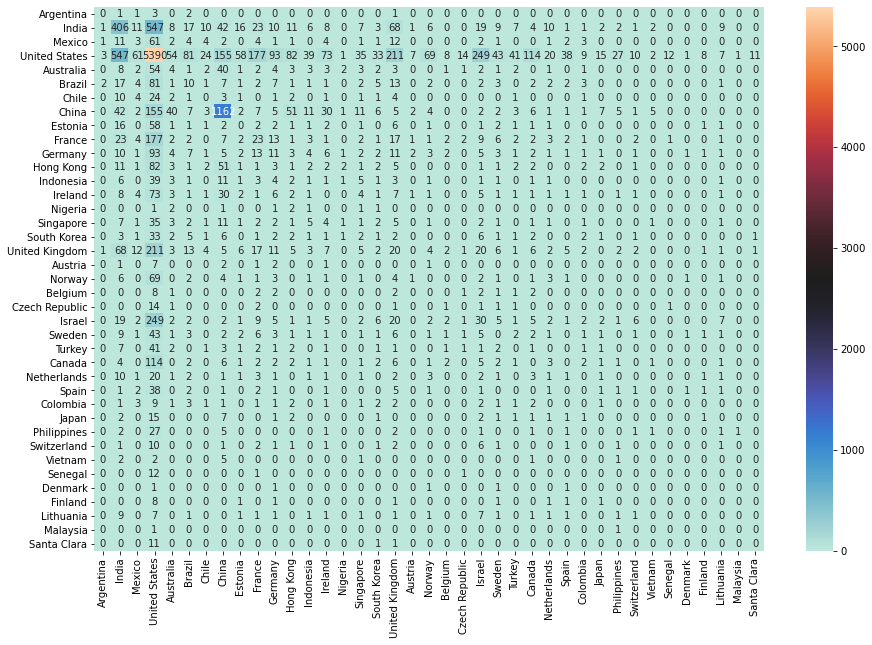

In [71]:
plt.figure(figsize=(15, 10))
center = (country_graph_matrix.max().max() - country_graph_matrix.min().min()) / 2
sns.heatmap(country_graph_matrix, center=center, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_dir, "adjacency", "country_graph.png"))

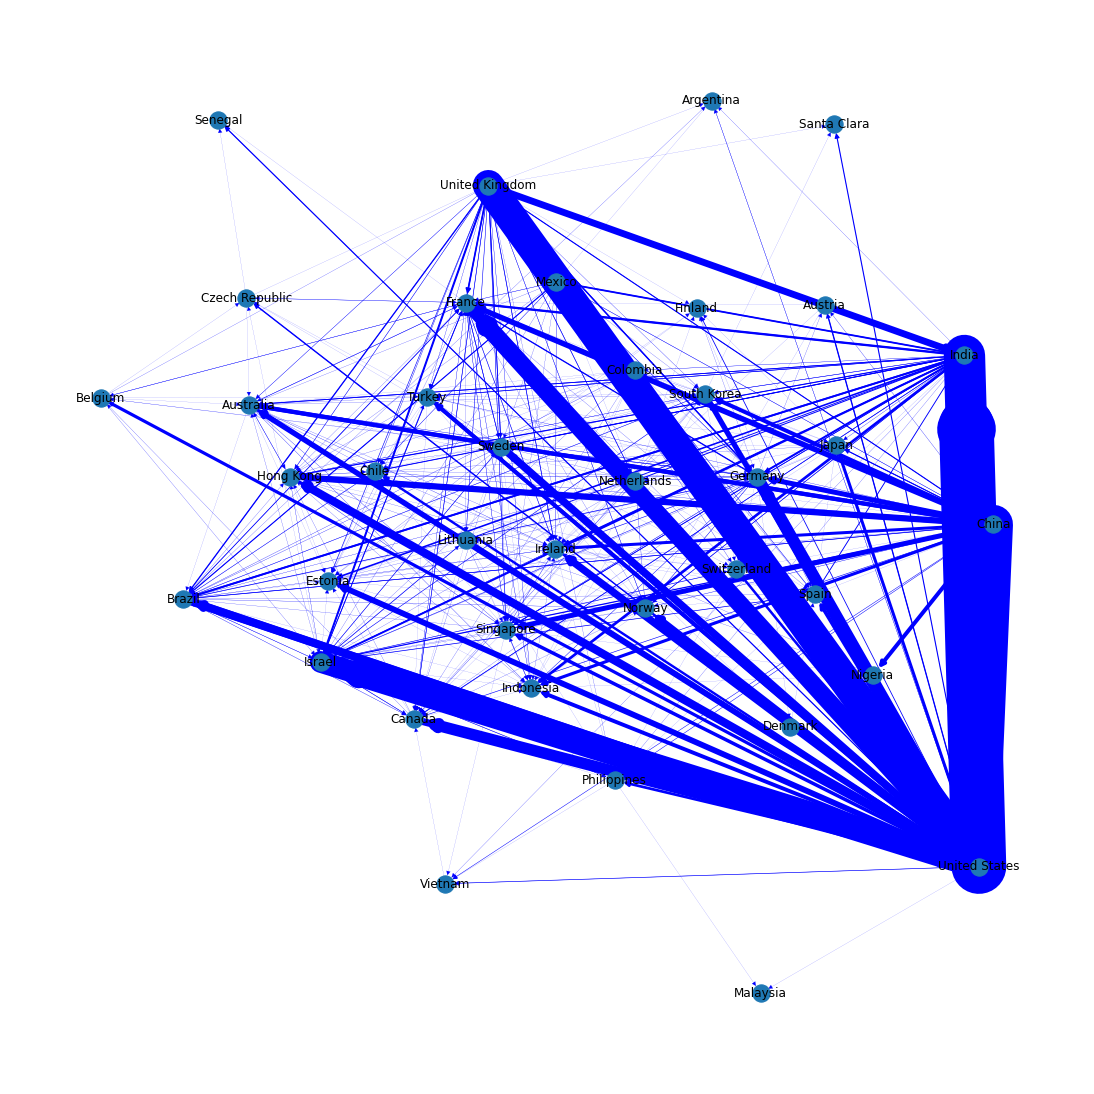

In [72]:
country_DG = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join(out_dir, "edgelist", "country_dgraph.png"))
country_dgraph_df.to_csv(os.path.join(out_dir, "edgelist", "country_dgraph.csv"), sep="\t")

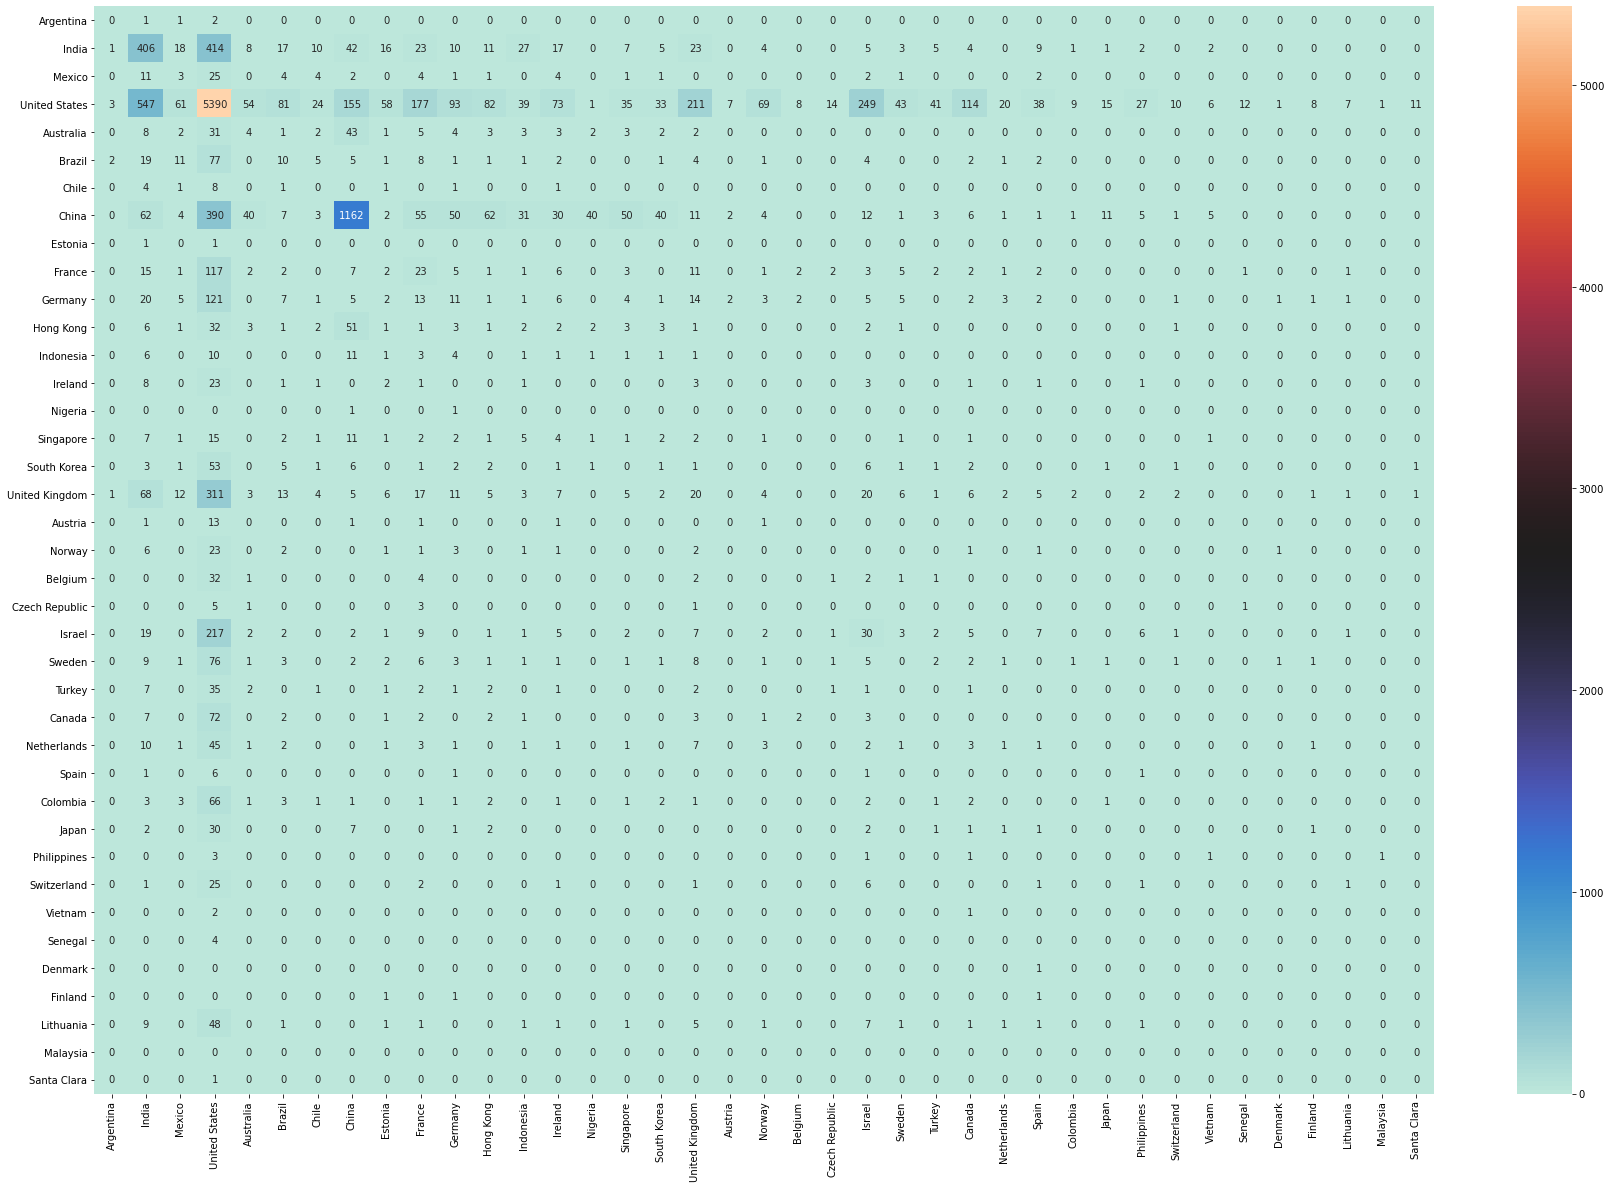

In [73]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
plt.figure(figsize=(30, 20))
center = (country_dgraph_matrix.max().max() - country_dgraph_matrix.min().min()) / 2
sns.heatmap(country_dgraph_matrix, center=center, annot=True, fmt=".0f") # , annot_kws={"fontsize":3}
plt.savefig(os.path.join(out_dir, "adjacency", "country_dgraph.png"))
country_dgraph_matrix.to_csv(os.path.join(out_dir, "adjacency", "country_dgraph.csv"))

In [74]:
industry_dgraph_df = country_industry_df.groupby(by=["Category_source", "Category_target"], as_index=False).agg({"source": 'count'})
industry_dgraph_df.columns = ["source", "target", "weight"]
industry_G = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join(out_dir, "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join(out_dir, "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,90
1,Artificial intelligence,Auto & transportation,22
2,Artificial intelligence,Consumer & retail,42
3,Artificial intelligence,Cybersecurity,36
4,Artificial intelligence,Data management & analytics,71


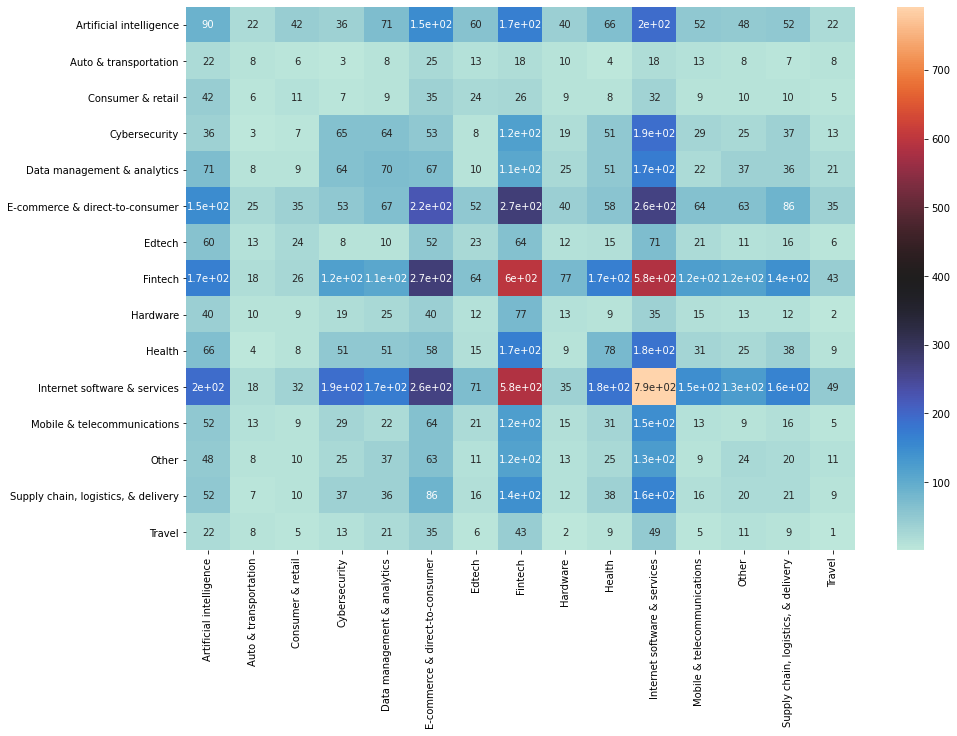

In [75]:
plt.figure(figsize=(15, 10))
center = (industry_graph_matrix.max().max() - industry_graph_matrix.min().min()) / 2
sns.heatmap(industry_graph_matrix, center=center, annot=True)
plt.savefig(os.path.join(out_dir, "adjacency", "industry_graph.png"))

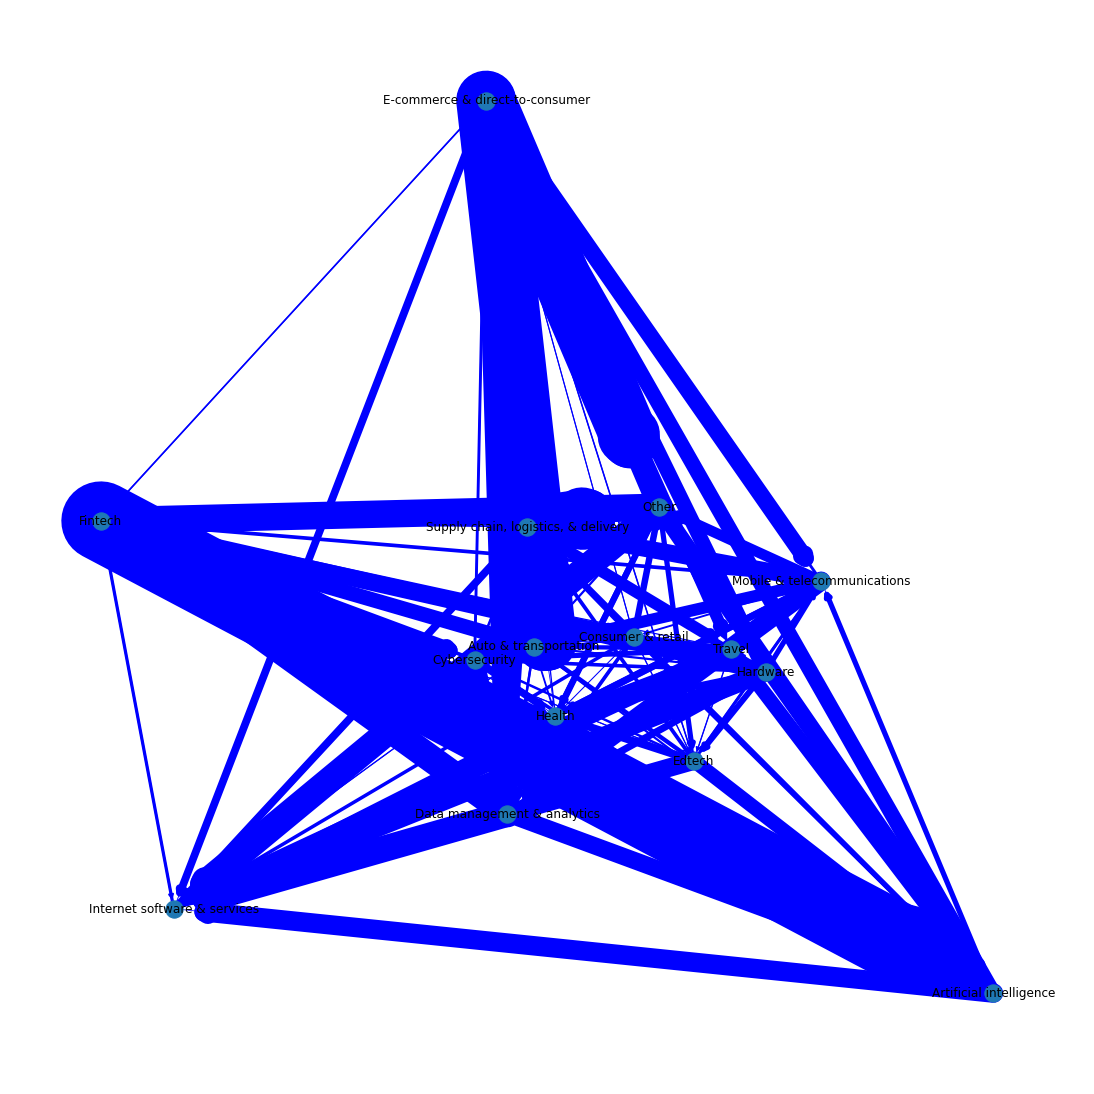

In [76]:
industry_DG = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join(out_dir, "edgelist", "industry_dgraph.png"))
industry_dgraph_df.to_csv(os.path.join(out_dir, "edgelist", "industry_dgraph.csv"), sep="\t")

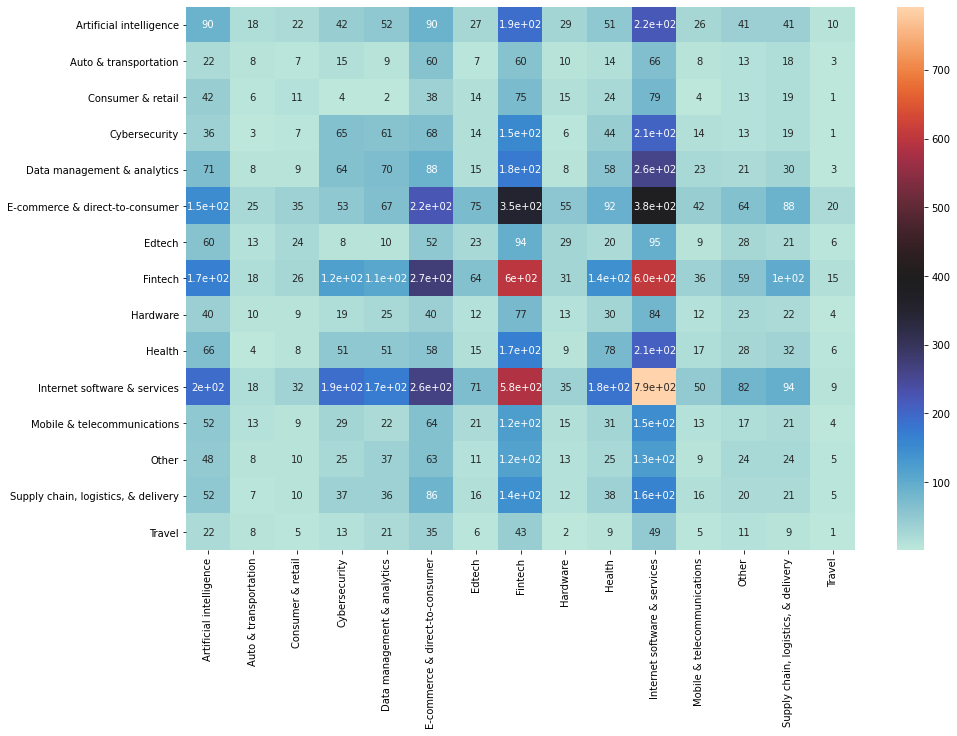

In [77]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
plt.figure(figsize=(15, 10))
center = (industry_dgraph_matrix.max().max() - industry_dgraph_matrix.min().min()) / 2
sns.heatmap(industry_dgraph_matrix, center=center, annot=True)
plt.savefig(os.path.join(out_dir, "adjacency", "industry_dgraph.png"))
industry_dgraph_matrix.to_csv(os.path.join(out_dir, "adjacency", "industry_dgraph.csv"))

In [78]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [79]:
country_centrality_df.to_csv(os.path.join(out_dir, "features", "country_unicorn_centrality.csv"))

In [80]:
industry_centrality_df.to_csv(os.path.join(out_dir, "features", "industry_unicorn_centrality.csv"))

# 回帰分析

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [82]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Rubicon Global,0.016502,0.000000,1.104478e-93,0.009935,0.000443,0.005501,0.011001,7,640,1.0,...,0.008242,0.0,$1.07,2017/8/25,United States,Other,"[Goldman Sachs, Leonardo DiCaprio, Promecap]",1.07,2017-08-25,1.07
VAST Data,0.034103,0.001937,1.670623e-57,0.056733,0.000890,0.018702,0.015402,6,401,1.0,...,0.017033,0.0,$3.70,2020/4/16,United States,Data management & analytics,"[Norwest Venture Partners, Goldman Sachs, De...",3.70,2020-04-16,3.70
Swiggy,0.013201,0.000000,5.335019e-108,0.001100,0.000368,0.001100,0.012101,6,402,1.0,...,0.006593,0.0,$10.70,2018/6/21,India,"Supply chain, logistics, & delivery","[Accel India, SAIF Partners, Norwest Venture...",10.70,2018-06-21,10.70
Klook,0.073707,0.003228,6.599511e-71,0.056873,0.000754,0.035204,0.038504,9,527,1.0,...,0.036813,0.0,$1.35,2018/8/7,Hong Kong,Travel,"[Sequoia Capital China, Goldman Sachs, Matri...",1.35,2018-08-07,1.35
Graphcore,0.009901,0.000392,1.213729e-105,0.001467,0.000397,0.001100,0.008801,7,421,1.0,...,0.004945,0.0,$2.77,2018/12/18,United Kingdom,Artificial intelligence,"[Dell Technologies Capital, Pitango Venture C...",2.77,2018-12-18,2.77


In [83]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation ($B) ', 'Date Added', 'Country',
       'Category', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [84]:
train_df = unicorn_data_df.drop([
    'Valuation ($B) ', 'Date Added', 'Country', 'Category', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Company,,,
Rubicon Global,0.011001,640,1.07
VAST Data,0.015402,401,3.70
Swiggy,0.012101,402,10.70
Klook,0.038504,527,1.35
Graphcore,0.008801,421,2.77


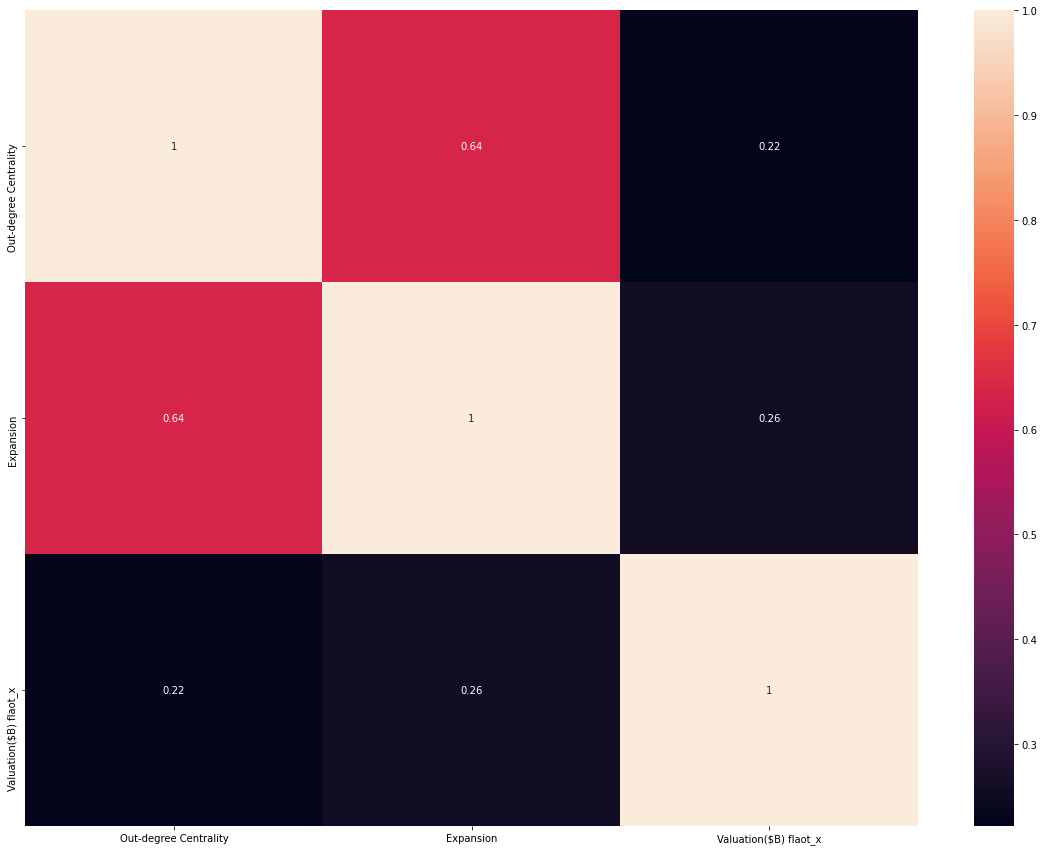

In [85]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [86]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [87]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Valuation($B) flaot_x   R-squared:                       0.071
Model:                               OLS   Adj. R-squared:                  0.069
Method:                    Least Squares   F-statistic:                     34.76
Date:                   Sun, 20 Feb 2022   Prob (F-statistic):           2.84e-15
Time:                           13:55:26   Log-Likelihood:                -1257.6
No. Observations:                    910   AIC:                             2521.
Df Residuals:                        907   BIC:                             2536.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.643e-17      0.032  -1.14e-15      1.000      -0.063       0.063
Out-degree Centrality     0.0984      0.042      2.366      0.018       0.017       0.180
Expansion                 0.1930      0.042      4.638      0.000       0.111       0.275
==============================================================================
Omnibus:                     1549.403   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           972727.180
Skew:                          10.933   Prob(JB):                         0.00
Kurtosis:                     161.670   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
train_df.corr()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Out-degree Centrality,1.000000,0.639052,0.221735
Expansion,0.639052,1.000000,0.255864
Valuation($B) flaot_x,0.221735,0.255864,1.000000


In [89]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

Out-degree Centrality    0.0
Expansion                0.0
dtype: float64

In [90]:
with open(os.path.join(out_dir, "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [91]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,EXOR Seeds,0.001706,0.000000,7.126810e-50,0.000000,0.000499,0.000000,0.001706,1,2,1.0,0.0,0.000853,0.0,1.00,1,1.000000,1,1,1
1,OLX Group,0.001706,0.000000,6.211229e-45,0.001706,0.001316,0.001706,0.000000,0,0,1.0,0.0,0.000853,0.0,1.00,1,1.000000,1,1,1
2,KCK Group,0.001706,0.000000,2.971880e-47,0.000853,0.000711,0.000853,0.000853,1,1,1.0,0.0,0.000853,0.0,1.00,1,1.000000,1,1,1
3,Sequoia Capital India,0.034983,0.001702,4.988946e-20,0.018606,0.000631,0.004266,0.030717,6,445,1.0,0.0,0.017477,0.0,88.33,26,3.397308,3,10,26
4,Kae Capital,0.001706,0.000000,4.821948e-13,0.023773,0.000539,0.001706,0.000000,0,0,1.0,0.0,0.000853,0.0,2.50,1,2.500000,1,1,1


In [92]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,1173.000000,1173.000000,1.173000e+03,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.0,1173.0,1173.000000,1173.0,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000
mean,0.003644,0.000083,1.671619e-03,0.011925,0.000853,0.001822,0.001822,1.487639,46.433930,1.0,0.0,0.001821,0.0,8.172540,2.389599,2.943423,1.376812,1.697357,2.389599
std,0.006083,0.000371,2.916240e-02,0.009353,0.000353,0.001683,0.005081,2.226713,159.466362,0.0,0.0,0.003039,0.0,23.034512,4.561389,6.145522,1.184891,1.642431,4.561389
min,0.000853,0.000000,7.126810e-50,0.000000,0.000499,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000426,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.001706,0.000000,8.613201e-43,0.001883,0.000566,0.000853,0.000000,0.000000,0.000000,1.0,0.0,0.000853,0.0,1.200000,1.000000,1.100000,1.000000,1.000000,1.000000
50%,0.001706,0.000000,1.554622e-20,0.011461,0.000734,0.001706,0.000853,1.000000,1.000000,1.0,0.0,0.000853,0.0,2.300000,1.000000,1.700000,1.000000,1.000000,1.000000
75%,0.003413,0.000009,6.580970e-12,0.019690,0.001031,0.001706,0.001706,1.000000,3.000000,1.0,0.0,0.001705,0.0,5.500000,2.000000,2.950000,1.000000,2.000000,2.000000
max,0.071672,0.005566,7.617111e-01,0.036872,0.002987,0.021331,0.057167,10.000000,885.000000,1.0,0.0,0.035806,0.0,341.880000,57.000000,100.300000,16.000000,13.000000,57.000000


In [93]:
investor_data_df = investor_data_df.set_index("Investor")

In [94]:
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,1173.000000,1173.000000,1173.000000,1173.000000
mean,0.000083,46.433930,2.389599,8.172540
std,0.000371,159.466362,4.561389,23.034512
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.200000
50%,0.000000,1.000000,1.000000,2.300000
75%,0.000009,3.000000,2.000000,5.500000
max,0.005566,885.000000,57.000000,341.880000


In [95]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [96]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total valuation($B)   R-squared:                       0.720
Model:                             OLS   Adj. R-squared:                  0.720
Method:                  Least Squares   F-statistic:                     1004.
Date:                 Sun, 20 Feb 2022   Prob (F-statistic):          8.89e-323
Time:                         13:55:26   Log-Likelihood:                -917.17
No. Observations:                 1173   AIC:                             1842.
Df Residuals:                     1169   BIC:                             1863.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -4.51e-17      0.015  -2.92e-15      1.000      -0.030       0.030
Betweenness Centrality    -0.1040      0.031     -3.345      0.001      -0.165      -0.043
Expansion                  0.0993      0.019      5.167      0.000       0.062       0.137
#unicorns                  0.8748      0.034     25.415      0.000       0.807       0.942
==============================================================================
Omnibus:                     1526.735   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           245487.104
Skew:                           6.963   Prob(JB):                         0.00
Kurtosis:                      72.490   Cond. No.                         4.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [98]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

Betweenness Centrality   -2.0
Expansion                 0.0
#unicorns                 0.0
dtype: float64

In [99]:
with open(os.path.join(out_dir, "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())